In [1]:
# --- Imports and Setup ---
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from tqdm import tqdm
from glob import glob
from torch.utils.data import DataLoader, TensorDataset

# Add the src directory to the Python path
sys.path.append(os.path.abspath(os.path.join('..', 'src')))
import config
from model import TransformerAutoencoder
from explainability import analyze_anomaly_with_xai
# We only need the benign data loader for this notebook's core function
from data_loader import load_and_preprocess_data

sns.set_style("whitegrid")

In [2]:
# --- Load Benign Data and Then the Trained Model ---
# Load data first to get the correct feature dimension.
try:
    # Correct path for notebook execution
    X_benign_sequences = load_and_preprocess_data()
    X_benign_tensor = torch.tensor(X_benign_sequences, dtype=torch.float32)
    num_features = X_benign_sequences.shape[2]
    print(f"Benign data loaded. Shape: {X_benign_tensor.shape}. Features: {num_features}")
except FileNotFoundError:
    print("Processed benign data not found. Please run `python src/data_loader.py` first to generate it.")
    X_benign_tensor = None
    num_features = config.INPUT_FEATURES # Fallback

# Load the model
if X_benign_tensor is not None:
    model = TransformerAutoencoder(
        input_features=num_features,
        model_dim=config.MODEL_DIM,
        num_heads=config.NUM_HEADS,
        num_encoder_layers=config.NUM_ENCODER_LAYERS,
        dim_feedforward=config.DIM_FEEDFORWARD,
        dropout=config.DROPOUT
    ).to(config.DEVICE)
    try:
        # Correct path for notebook execution
        model_path = os.path.join('..', config.MODEL_SAVE_PATH)
        model.load_state_dict(torch.load(model_path, map_location=config.DEVICE))
        model.eval()
        print("Trained model loaded successfully.")
    except FileNotFoundError:
        print(f"Model not found at {model_path}. Please run `python src/train.py` first.")
        model = None
else:
    model = None

Preprocessed benign data and scaler found. Loading from cache...
Benign data loaded. Shape: torch.Size([56326, 100, 84]). Features: 84
Trained model loaded successfully.


Calculating Reconstruction Errors: 100%|██████████| 40/40 [00:02<00:00, 14.50it/s]


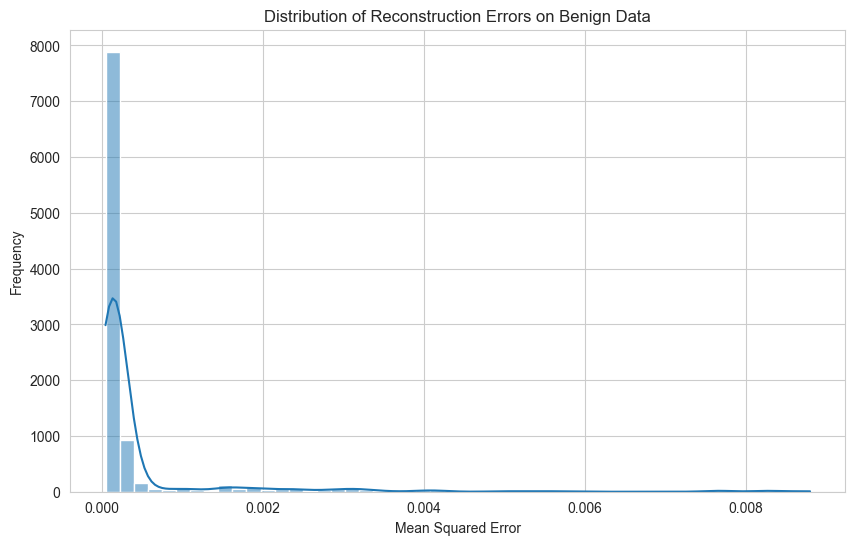

99th percentile of reconstruction errors: 0.005902
A good starting threshold for anomaly detection could be around 0.005902


In [3]:
# --- Calculate and Visualize Reconstruction Errors ---
# This is crucial for setting the anomaly detection threshold.
if model and X_benign_tensor is not None:
    reconstruction_errors = []
    with torch.no_grad():
        # Use a dataloader for efficient batch processing
        dataset = TensorDataset(X_benign_tensor[:10000])
        loader = DataLoader(dataset, batch_size=256)
        
        for batch in tqdm(loader, desc="Calculating Reconstruction Errors"):
            seqs = batch[0].to(config.DEVICE)
            reconstructions = model(seqs)
            errors = torch.mean((seqs - reconstructions) ** 2, dim=(1, 2))
            reconstruction_errors.extend(errors.cpu().numpy())

    plt.figure(figsize=(10, 6))
    sns.histplot(reconstruction_errors, bins=50, kde=True)
    plt.title('Distribution of Reconstruction Errors on Benign Data')
    plt.xlabel('Mean Squared Error')
    plt.ylabel('Frequency')
    plt.show()

    threshold = np.percentile(reconstruction_errors, 99)
    print(f"99th percentile of reconstruction errors: {threshold:.6f}")
    print(f"A good starting threshold for anomaly detection could be around {threshold:.6f}")


In [4]:
# --- Analyze a Synthetic Anomaly ---
# This cell creates a noisy sequence to quickly test the XAI functionality.
if model:
    print("\n--- Analyzing a Synthetic Anomaly ---")
    if X_benign_tensor is not None:
        benign_sequence = X_benign_tensor[0].numpy()
        noise = np.random.normal(0, 0.8, size=benign_sequence.shape)
        simulated_anomaly = benign_sequence + noise
        
        print("Generating attention map for a synthetic (noisy) anomaly...")
        analyze_anomaly_with_xai(model, simulated_anomaly, "Synthetic_Noise")
        plt.show() # Display the plot in the notebook
    else:
        print("Benign data not loaded, skipping synthetic anomaly analysis.")


--- Analyzing a Synthetic Anomaly ---
Generating attention map for a synthetic (noisy) anomaly...

Attention heatmap for 'Synthetic_Noise' saved to: results/attention_heatmap_Synthetic_Noise.png


In [5]:
# --- Analyze a Real Attack Vector from an Individual Cache File ---
# This cell now finds and loads one of the specific attack cache files.
if model:
    print("\n--- Analyzing a Real Attack Vector for Each Attack Type ---")
    try:
        # Find available attack cache files
        attack_files_path = os.path.join('..', config.PROCESSED_DATA_DIR, 'X_attack_*.npy')
        attack_files = glob(attack_files_path)
        
        if not attack_files:
            raise FileNotFoundError("No attack cache files found. Run `src/data_loader.py` to create them.")

        # Loop through each attack file and generate a heatmap
        for attack_file_to_analyze in attack_files:
            attack_type = os.path.basename(attack_file_to_analyze).replace('X_attack_', '').replace('.npy', '')
            
            print(f"\nLoading attack data for '{attack_type}' from {attack_file_to_analyze}...")
            attack_sequences = np.load(attack_file_to_analyze)
            
            if attack_sequences.shape[0] > 0:
                # Get a random sequence from the attack data
                random_index = np.random.randint(0, len(attack_sequences))
                real_attack_sequence = attack_sequences[random_index]
                
                print(f"Generating attention map for a real '{attack_type}' sequence (index {random_index})...")
                analyze_anomaly_with_xai(model, real_attack_sequence, attack_type)
                plt.show() # Display the plot for this attack type
            else:
                print(f"The attack cache file for '{attack_type}' is empty. Cannot perform analysis.")
            
    except (FileNotFoundError, ValueError, Exception) as e:
        print(f"Could not analyze attack data: {e}")
        print("Please ensure you have run `python src/data_loader.py` at least once from the project root.")



--- Analyzing a Real Attack Vector for Each Attack Type ---

Loading attack data for 'TFTP' from ../data/processed/X_attack_TFTP.npy...
Generating attention map for a real 'TFTP' sequence (index 23858)...

Attention heatmap for 'TFTP' saved to: results/attention_heatmap_TFTP.png

Loading attack data for 'WebDDoS' from ../data/processed/X_attack_WebDDoS.npy...
Generating attention map for a real 'WebDDoS' sequence (index 133)...

Attention heatmap for 'WebDDoS' saved to: results/attention_heatmap_WebDDoS.png

Loading attack data for 'Syn' from ../data/processed/X_attack_Syn.npy...
Generating attention map for a real 'Syn' sequence (index 54084)...

Attention heatmap for 'Syn' saved to: results/attention_heatmap_Syn.png

Loading attack data for 'DrDoS_DNS' from ../data/processed/X_attack_DrDoS_DNS.npy...
Generating attention map for a real 'DrDoS_DNS' sequence (index 58679)...

Attention heatmap for 'DrDoS_DNS' saved to: results/attention_heatmap_DrDoS_DNS.png

Loading attack data for '